# 1. IMPORT

In [1]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()


In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from pytorchtools import EarlyStopping

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# 하이퍼파라미터 설정

In [6]:
import os
os.getcwd()

'/home/work/CL/largecode2modify'

In [7]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.0004
        self.batch_size=16
        self.shuffle = True
        self.seed=42
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/ict/ict5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [9]:
# trainset.to_pickle('/home/work/CL/dataset/ict_train.pickle')
# testset.to_pickle('/home/work/CL/dataset/ict_test.pickle')
# valset.to_pickle('/home/work/CL/dataset/ict_val.pickle')

trainset = pd.read_pickle('/home/work/CL/dataset/ict/ict_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/ict/ict_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/ict/ict_val.pickle')

In [10]:
trainset['수도라벨'].value_counts()

2    626
4    606
1    595
0    592
3    581
Name: 수도라벨, dtype: int64

# 토크나이저와 모델 정의

In [11]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model
# parallel_model = torch.nn.DataParallel(model)
# model = get_peft_model(model, peft_config).to(device)

# model.print_trainable_parameters()
# model


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

# 커스텀 데이터셋

In [12]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [13]:
train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                           labels= list(trainset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=True,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [14]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [15]:
def validate(epoch, model, loader):
   
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [16]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return  t_avg_loss, t_avg_acc
    
        

# RUN

In [17]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.0004)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.1* (len(train_loader) * cfg.epochs),
    num_training_steps=(len(train_loader) * cfg.epochs),
)

In [18]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)

for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, train_loader)

    lr_scheduler.step()

    
    validate(epoch, model, val_loader)
    

    # if early_stopping.early_stop:
        # break
    
    torch.save(model.state_dict(), f'/home/work/CL/final_ictmodel/ict{epoch+1}epoch.pt')
    
    
    # index = index + 1
df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_ictmodel/ict.xlsx', index=False)    

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 2.4479548931121826
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 2.4335222244262695
1_32_step_정확도 :0.0
Epoch : 1, train_64_step_loss : 2.3903791904449463
1_64_step_정확도 :0.0625
Epoch : 1, train_96_step_loss : 2.3987019062042236
1_96_step_정확도 :0.0
Epoch : 1, train_128_step_loss : 2.390453338623047
1_128_step_정확도 :0.0625
Epoch : 1, train_160_step_loss : 2.4158451557159424
1_160_step_정확도 :0.0
Epoch:1, train_187_stepLoss:2.4212751908505217
Epoch:1, train_187_stepacc:0.014295212765957447
Epoch:1, train_187_stepacc:0.014295212765957447
Epoch : 1, val_0_step_loss : 2.3496651649475098
1_0_step_정확도 :0.0
Epoch : 1, val_32_step_loss : 2.386972665786743
1_32_step_정확도 :0.0
Epoch:1, val_62_stepLoss:2.4152958430941145
Epoch:1, val_62_stepacc:0.0
Epoch:1, val_62_stepacc:0.0
Validation loss decreased (inf --> 2.415296).  Saving model ...


 10%|█         | 1/10 [01:32<13:50, 92.26s/it]

Epoch : 2, train_0_step_loss : 2.421674966812134
2_0_step_정확도 :0.0
Epoch : 2, train_32_step_loss : 1.9672859907150269
2_32_step_정확도 :0.1875
Epoch : 2, train_64_step_loss : 1.7450741529464722
2_64_step_정확도 :0.125
Epoch : 2, train_96_step_loss : 1.6690400838851929
2_96_step_정확도 :0.3125
Epoch : 2, train_128_step_loss : 1.3872114419937134
2_128_step_정확도 :0.625
Epoch : 2, train_160_step_loss : 1.44061279296875
2_160_step_정확도 :0.5
Epoch:2, train_187_stepLoss:1.6667872264664223
Epoch:2, train_187_stepacc:0.3583776595744681
Epoch:2, train_187_stepacc:0.3583776595744681
Epoch : 2, val_0_step_loss : 1.2939141988754272
2_0_step_정확도 :0.3125
Epoch : 2, val_32_step_loss : 1.3370254039764404
2_32_step_정확도 :0.5
Epoch:2, val_62_stepLoss:1.1882020017457386
Epoch:2, val_62_stepacc:0.5595238095238095
Epoch:2, val_62_stepacc:0.5595238095238095
Validation loss decreased (2.415296 --> 1.188202).  Saving model ...


 20%|██        | 2/10 [03:04<12:17, 92.23s/it]

Epoch : 3, train_0_step_loss : 0.9215838313102722
3_0_step_정확도 :0.75
Epoch : 3, train_32_step_loss : 1.2433645725250244
3_32_step_정확도 :0.375
Epoch : 3, train_64_step_loss : 1.032126545906067
3_64_step_정확도 :0.75
Epoch : 3, train_96_step_loss : 0.8770873546600342
3_96_step_정확도 :0.625
Epoch : 3, train_128_step_loss : 0.7473778128623962
3_128_step_정확도 :0.8125
Epoch : 3, train_160_step_loss : 1.2689603567123413
3_160_step_정확도 :0.5625
Epoch:3, train_187_stepLoss:1.0599317135328943
Epoch:3, train_187_stepacc:0.5857712765957447
Epoch:3, train_187_stepacc:0.5857712765957447
Epoch : 3, val_0_step_loss : 0.9655863642692566
3_0_step_정확도 :0.6875
Epoch : 3, val_32_step_loss : 1.2524309158325195
3_32_step_정확도 :0.5
Epoch:3, val_62_stepLoss:1.0224223117979745
Epoch:3, val_62_stepacc:0.6011904761904762
Epoch:3, val_62_stepacc:0.6011904761904762
Validation loss decreased (1.188202 --> 1.022422).  Saving model ...


 30%|███       | 3/10 [04:36<10:45, 92.24s/it]

Epoch : 4, train_0_step_loss : 0.8840527534484863
4_0_step_정확도 :0.625
Epoch : 4, train_32_step_loss : 0.9741132259368896
4_32_step_정확도 :0.625
Epoch : 4, train_64_step_loss : 1.2218507528305054
4_64_step_정확도 :0.5
Epoch : 4, train_96_step_loss : 0.8767566680908203
4_96_step_정확도 :0.625
Epoch : 4, train_128_step_loss : 0.616556704044342
4_128_step_정확도 :0.875
Epoch : 4, train_160_step_loss : 0.5545348525047302
4_160_step_정확도 :0.75
Epoch:4, train_187_stepLoss:0.8631859913151315
Epoch:4, train_187_stepacc:0.6595744680851063
Epoch:4, train_187_stepacc:0.6595744680851063
Epoch : 4, val_0_step_loss : 1.045844316482544
4_0_step_정확도 :0.5
Epoch : 4, val_32_step_loss : 1.465751051902771
4_32_step_정확도 :0.5625
Epoch:4, val_62_stepLoss:1.0125758567499736
Epoch:4, val_62_stepacc:0.6408730158730159
Epoch:4, val_62_stepacc:0.6408730158730159
Validation loss decreased (1.022422 --> 1.012576).  Saving model ...


 40%|████      | 4/10 [06:09<09:13, 92.29s/it]

Epoch : 5, train_0_step_loss : 0.8849478363990784
5_0_step_정확도 :0.625
Epoch : 5, train_32_step_loss : 0.7088657021522522
5_32_step_정확도 :0.6875
Epoch : 5, train_64_step_loss : 0.48828136920928955
5_64_step_정확도 :0.8125
Epoch : 5, train_96_step_loss : 0.6747603416442871
5_96_step_정확도 :0.75
Epoch : 5, train_128_step_loss : 0.41775038838386536
5_128_step_정확도 :0.75
Epoch : 5, train_160_step_loss : 0.7961665391921997
5_160_step_정확도 :0.5
Epoch:5, train_187_stepLoss:0.6784875475345774
Epoch:5, train_187_stepacc:0.7273936170212766
Epoch:5, train_187_stepacc:0.7273936170212766
Epoch : 5, val_0_step_loss : 0.909453809261322
5_0_step_정확도 :0.625
Epoch : 5, val_32_step_loss : 1.4197607040405273
5_32_step_정확도 :0.6875
Epoch:5, val_62_stepLoss:1.0134057695903476
Epoch:5, val_62_stepacc:0.6537698412698413
Epoch:5, val_62_stepacc:0.6537698412698413
EarlyStopping counter: 1 out of 3


 50%|█████     | 5/10 [07:38<07:37, 91.42s/it]

Epoch : 6, train_0_step_loss : 0.2595039904117584
6_0_step_정확도 :0.875
Epoch : 6, train_32_step_loss : 0.23811940848827362
6_32_step_정확도 :0.9375
Epoch : 6, train_64_step_loss : 0.3355904221534729
6_64_step_정확도 :0.9375
Epoch : 6, train_96_step_loss : 0.6570839881896973
6_96_step_정확도 :0.6875
Epoch : 6, train_128_step_loss : 0.2952011525630951
6_128_step_정확도 :0.875
Epoch : 6, train_160_step_loss : 0.2956218123435974
6_160_step_정확도 :0.875
Epoch:6, train_187_stepLoss:0.4937627485933456
Epoch:6, train_187_stepacc:0.8091755319148937
Epoch:6, train_187_stepacc:0.8091755319148937
Epoch : 6, val_0_step_loss : 0.9088704586029053
6_0_step_정확도 :0.8125
Epoch : 6, val_32_step_loss : 1.6139001846313477
6_32_step_정확도 :0.5
Epoch:6, val_62_stepLoss:1.2400595209901295
Epoch:6, val_62_stepacc:0.6180555555555556
Epoch:6, val_62_stepacc:0.6180555555555556
EarlyStopping counter: 2 out of 3


 60%|██████    | 6/10 [09:09<06:03, 90.98s/it]

Epoch : 7, train_0_step_loss : 0.39032700657844543
7_0_step_정확도 :0.875
Epoch : 7, train_32_step_loss : 0.5031856894493103
7_32_step_정확도 :0.9375
Epoch : 7, train_64_step_loss : 0.5212246775627136
7_64_step_정확도 :0.75
Epoch : 7, train_96_step_loss : 0.4549911916255951
7_96_step_정확도 :0.8125
Epoch : 7, train_128_step_loss : 0.38084542751312256
7_128_step_정확도 :0.875
Epoch : 7, train_160_step_loss : 0.9218022227287292
7_160_step_정확도 :0.75
Epoch:7, train_187_stepLoss:0.3779529497978535
Epoch:7, train_187_stepacc:0.8570478723404256
Epoch:7, train_187_stepacc:0.8570478723404256
Epoch : 7, val_0_step_loss : 0.8209841251373291
7_0_step_정확도 :0.75
Epoch : 7, val_32_step_loss : 1.7622696161270142
7_32_step_정확도 :0.5625
Epoch:7, val_62_stepLoss:1.2915672007061185
Epoch:7, val_62_stepacc:0.6140873015873016
Epoch:7, val_62_stepacc:0.6140873015873016
EarlyStopping counter: 3 out of 3


 70%|███████   | 7/10 [10:40<04:33, 91.03s/it]

Epoch : 8, train_0_step_loss : 0.2513905167579651
8_0_step_정확도 :0.875
Epoch : 8, train_32_step_loss : 0.2250089943408966
8_32_step_정확도 :0.875
Epoch : 8, train_64_step_loss : 0.1206585019826889
8_64_step_정확도 :1.0
Epoch : 8, train_96_step_loss : 0.35315823554992676
8_96_step_정확도 :0.875
Epoch : 8, train_128_step_loss : 0.566136360168457
8_128_step_정확도 :0.8125
Epoch : 8, train_160_step_loss : 0.22629645466804504
8_160_step_정확도 :0.875
Epoch:8, train_187_stepLoss:0.2681315937773027
Epoch:8, train_187_stepacc:0.9075797872340425
Epoch:8, train_187_stepacc:0.9075797872340425
Epoch : 8, val_0_step_loss : 0.7730578184127808
8_0_step_정확도 :0.8125
Epoch : 8, val_32_step_loss : 1.9129976034164429
8_32_step_정확도 :0.625
Epoch:8, val_62_stepLoss:1.4905521718282548
Epoch:8, val_62_stepacc:0.626984126984127
Epoch:8, val_62_stepacc:0.626984126984127
EarlyStopping counter: 4 out of 3


 80%|████████  | 8/10 [12:10<03:01, 90.86s/it]

Epoch : 9, train_0_step_loss : 0.2576172649860382
9_0_step_정확도 :0.9375
Epoch : 9, train_32_step_loss : 0.2184063047170639
9_32_step_정확도 :0.9375
Epoch : 9, train_64_step_loss : 0.294662207365036
9_64_step_정확도 :0.9375
Epoch : 9, train_96_step_loss : 0.15798348188400269
9_96_step_정확도 :0.875
Epoch : 9, train_128_step_loss : 0.3016335070133209
9_128_step_정확도 :0.9375
Epoch : 9, train_160_step_loss : 0.16296230256557465
9_160_step_정확도 :0.9375
Epoch:9, train_187_stepLoss:0.23651997646950979
Epoch:9, train_187_stepacc:0.9148936170212766
Epoch:9, train_187_stepacc:0.9148936170212766
Epoch : 9, val_0_step_loss : 1.1511174440383911
9_0_step_정확도 :0.6875
Epoch : 9, val_32_step_loss : 1.7892868518829346
9_32_step_정확도 :0.5625
Epoch:9, val_62_stepLoss:1.600222012353322
Epoch:9, val_62_stepacc:0.6041666666666666
Epoch:9, val_62_stepacc:0.6041666666666666
EarlyStopping counter: 5 out of 3


 90%|█████████ | 9/10 [13:41<01:30, 90.69s/it]

Epoch : 10, train_0_step_loss : 0.17241862416267395
10_0_step_정확도 :0.9375
Epoch : 10, train_32_step_loss : 0.6572484374046326
10_32_step_정확도 :0.8125
Epoch : 10, train_64_step_loss : 0.2962157130241394
10_64_step_정확도 :0.875
Epoch : 10, train_96_step_loss : 0.6495141386985779
10_96_step_정확도 :0.8125
Epoch : 10, train_128_step_loss : 0.19008827209472656
10_128_step_정확도 :0.9375
Epoch : 10, train_160_step_loss : 0.20933006703853607
10_160_step_정확도 :0.9375
Epoch:10, train_187_stepLoss:0.26594705892072873
Epoch:10, train_187_stepacc:0.910904255319149
Epoch:10, train_187_stepacc:0.910904255319149
Epoch : 10, val_0_step_loss : 1.0941822528839111
10_0_step_정확도 :0.75
Epoch : 10, val_32_step_loss : 2.481658697128296
10_32_step_정확도 :0.5
Epoch:10, val_62_stepLoss:1.6405454944996607
Epoch:10, val_62_stepacc:0.6031746031746031
Epoch:10, val_62_stepacc:0.6031746031746031
EarlyStopping counter: 6 out of 3


100%|██████████| 10/10 [15:11<00:00, 91.15s/it]


In [19]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,2.421275,2.415296,0.014295,0.000000
1,2,1.666787,1.188202,0.358378,0.559524
2,3,1.059932,1.022422,0.585771,0.601190
3,4,0.863186,1.012576,0.659574,0.640873
4,5,0.678488,1.013406,0.727394,0.653770
5,6,0.493763,1.240060,0.809176,0.618056
6,7,0.377953,1.291567,0.857048,0.614087
7,8,0.268132,1.490552,0.907580,0.626984
8,9,0.236520,1.600222,0.914894,0.604167
9,10,0.265947,1.640545,0.910904,0.603175


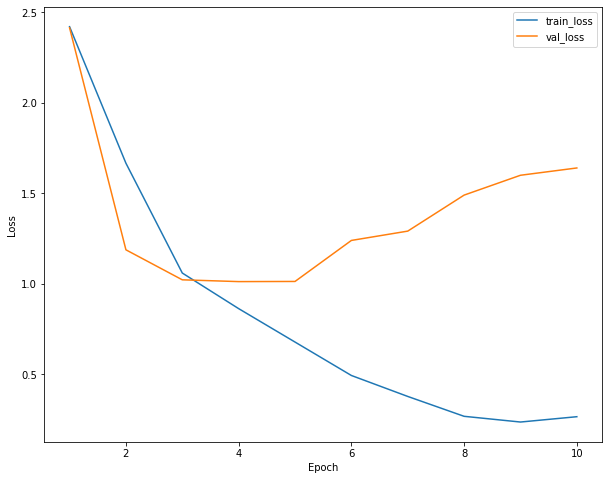

In [20]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(df1['epoch'],df1['train_loss'],label='train_loss')
plt.plot(df1['epoch'],df1['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

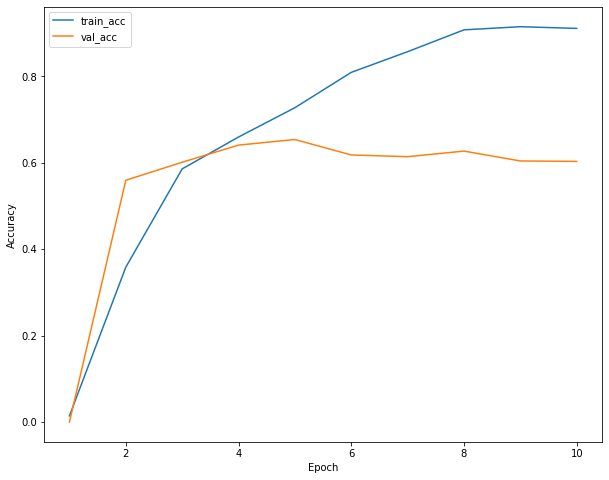

In [21]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(df1['epoch'],df1['train_acc'],label='train_acc')
plt.plot(df1['epoch'],df1['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

In [22]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model


for i in range(10) :
    save_path = f"/home/work/CL/final_ictmodel/ict{i+1}epoch.pt"
    model_state_dict = torch.load(save_path, map_location=device)
    model.load_state_dict(model_state_dict)
    
    print(i+1,infer(model=model,loader=test_loader))



63it [00:08,  7.81it/s]


test_62_stepLoss:2.4159151145390103
test_62_stepacc:0.0
1 (2.4159151145390103, 0.0)


63it [00:08,  7.76it/s]


test_62_stepLoss:1.2250436601184664
test_62_stepacc:0.5297619047619048
2 (1.2250436601184664, 0.5297619047619048)


63it [00:08,  7.66it/s]


test_62_stepLoss:1.044990484203611
test_62_stepacc:0.6011904761904762
3 (1.044990484203611, 0.6011904761904762)


63it [00:08,  7.70it/s]


test_62_stepLoss:1.0426089498731825
test_62_stepacc:0.6140873015873016
4 (1.0426089498731825, 0.6140873015873016)


63it [00:08,  7.70it/s]


test_62_stepLoss:1.073158680919617
test_62_stepacc:0.6200396825396826
5 (1.073158680919617, 0.6200396825396826)


63it [00:08,  7.78it/s]


test_62_stepLoss:1.2782233934553842
test_62_stepacc:0.6081349206349206
6 (1.2782233934553842, 0.6081349206349206)


63it [00:08,  7.72it/s]


test_62_stepLoss:1.3520870274967618
test_62_stepacc:0.6170634920634921
7 (1.3520870274967618, 0.6170634920634921)


63it [00:08,  7.74it/s]


test_62_stepLoss:1.5326116222237784
test_62_stepacc:0.6140873015873016
8 (1.5326116222237784, 0.6140873015873016)


63it [00:08,  7.68it/s]


test_62_stepLoss:1.630462440233382
test_62_stepacc:0.6180555555555556
9 (1.630462440233382, 0.6180555555555556)


63it [00:08,  7.69it/s]

test_62_stepLoss:1.7110564585716006
test_62_stepacc:0.6061507936507936
10 (1.7110564585716006, 0.6061507936507936)
